In [1]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.sparse.linalg import spsolve
import qdldl
from scipy.sparse import block_array,eye_array
import scipy
from sparse_dot_mkl import dot_product_mkl
import time
from util import PrettyLogger,get_step_size,maxnorm,norm2
from warnings import warn

In [11]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [12]:
from scipy.stats import Uniform


m = 10000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.01,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 1.*diags_array(np.ones(n))

rng = np.random.default_rng(10)

xx = rng.normal(size = n)
samp = Uniform(a = -0.5,b = 0.5).sample

C = random_array((200,n),
                 density = 0.2,rng = rng)



In [13]:
c = C@xx + 0.01
Q = 1e-7*diags_array(np.ones(n))
f = LogisticNLL(y,w)



In [ ]:
from dataclasses import dataclass

@dataclass
class SolverSettings():
    max_precenter = 100
    max_iter = 200
    tol = 1e-7
    boundary_frac = 0.99
    gamma = 0.5
    min_mu = 1e-10
    tau_reg =1e-12
    max_linesearch_steps = 50
    verbose = True


class GLMProblem():
    def __init__(
        self,
        f,A,Q,C,c,
        b=None,
        settings = None
        ):
        if settings is None:
            settings = SolverSettings()
        

        self.settings = settings
        
        m = A.shape[0]
        n = A.shape[1]
        assert A.shape[1] == C.shape[1]
        A = csc_array(A)

        #TODO:Separate solver dispatch for unconstrained
        assert C.shape[0] == len(c)
        C = csc_array(C)
        k = C.shape[0]
        self.k = k
        self.c = c

        if b is None:
            b = np.zeros(n)
        self.b = b
        
        
        if settings.verbose is True:
            print(f"{k} constraints")
            print(f"{n} variables")
            print(f"{m} rows in A")
        self.f = f
        self.A = A
        self.Q = Q
        self.C = C
        self.m = m
        self.n = n
        self.In = csc_array(eye_array(n))
        self.Ik = csc_array(eye_array(k))
    
    def initialize(self,x0=None,y0 = None,s0 = None):
        if x0 is None:
            x = np.zeros(self.n)
        else:
            x = np.copy(x0)
        
        if y0 is None:
            y = np.ones(self.k)
        else:
            y = np.copy(y0)
            assert np.min(y)>1e-8
        
        if s0 is None:
            s = np.maximum(self.c - self.C@x,0.01)
        else:
            s = np.copy(s0)
        
        return x,y,s
    
    def KKT_res(self,x,g,y,s,mu):
        rx = g + self.C.T@y - self.b
        rp = self.C@x + s - self.c
        rc = y * s - mu
        return rx,rp,rc
    
    def solve_KKT(
        self,
        x,y,s,H,rx,rp,rc,mu,tau_reg=None,
        solver = None):
        #mu,x unused for now

        if tau_reg is None:
            tau_reg = self.settings.tau_reg
        #Nesterov-Todd scaling
        # Quasi definite for inequality constraints, 
        # "normal equations" Hessian for GLM part
        w = np.sqrt(y/s)
        wC = self.C.multiply(w[:,None])
        #Including tiny tau-shift here
        #later may want separate matrix,
        #larger tau shift + iterative refine
        G = block_array(
            [
                [H+self.settings.tau_reg*self.In,wC.T],
                [wC,-1*self.Ik]
            ],format = 'csc'
        )
        rhs = np.hstack([-rx,-w*rp + (w/y) * rc])
        if solver is None:
            solver = qdldl.Solver(G)
        else:
            solver.update(G)
        sol = solver.solve(rhs)
        # linres = rhs - G@sol
        dx = sol[:self.n]
        dy = w*sol[self.n:]
        ds = -rp - self.C@dx
        return dx,ds,dy,solver
    
    def get_H(self,z):
        D = self.f.d2f(z)[:,None]
        AtDa = dot_product_mkl(self.A.T,csc_array(self.A.multiply(D)))
        return AtDa + self.Q
    
    def solve(
        self,
        x0=None,
        y0=None,
        s0=None
        ):
        x,y,s = self.initialize(x0,y0,s0)
        logger = PrettyLogger()
        settings = self.settings
        feasible = False
        armijo_param = 0.01

        start = time.time()
            
        mu = 100.

        z = self.A@x
        H = self.get_H(z)
        gradf = self.A.T@self.f.d1f(z) + self.Q@x
        rx,rp,rc = self.KKT_res(x,gradf,y,s,mu)
        kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu), get r
            )

        
        solver = None    
        for i in range(settings.max_iter):
            if maxnorm(rp)<1e-8:
                feasible = True
            if kkt_res<=settings.tol:
                break


            if feasible is False:
                tau_reg = 0.1 * np.mean(H.diagonal())
            else:
                tau_reg = self.settings.tau_reg

            dx,ds,dy,solver = self.solve_KKT(x,y,s,H,rx,rp,rc,mu,tau_reg,solver)
            tmax = get_step_size(s,ds,y,dy,frac = settings.boundary_frac)
            #Linesearch procedure here

            #Set up merit function
            primal = self.f(z) + (1/2) * x.T@self.Q@x - np.dot(x,self.b)
            barrier = -mu*np.sum(np.log(s))
            merit0 = primal + barrier

            gx = A.T@self.f.d1f(z) + Q@x - self.b
            gs = -mu/s


            t = tmax
            dz = A@dx
            Cdx = C@dx
            #Check implicit feasibility of f(x+t*dz)
            step_finite = self.f(z + t*dz)<np.inf
            
            #Accept every step if feasible is false and don't nan on the f
            #only enter linesearch if already feasible
            if (feasible is True) and (step_finite is True):
                def merit_line(t):
                    primal = self.f(z+t*dz) + (1/2) * (x+t*dx).T@self.Q@(x+t*dx) - np.dot(x,self.b)
                    barrier = -mu*np.sum(np.log(s+t*ds))
                    cons2 = norm2(rp+(Cdx) + ds)/2
                    return primal + barrier
                successful = False
                for linesearch_step in range(settings.max_linesearch_steps):
                    new_merit = merit_line(t)
                    if new_merit<merit0 + armijo_param * t * (np.dot(dx,gx) + np.dot(ds,gs)):
                        successful = True
                        break
                    else:
                        t = 0.9*t
                if successful ==False:
                    warn("Linesearch Failed!")
                    return x,logger.to_dataframe()
            
            #Take step
            x = x + t*dx
            s = s + t*ds
            y = y + t*dy
            z = self.A@x
            H = self.get_H(z)
            gradf = self.A.T@self.f.d1f(z) + self.Q@x

            if kkt_res<=100 * mu:
                mu_est = np.dot(s,y)/self.k
                xi = np.min(s*y)/mu_est
                mu_lower = np.maximum(mu*0.01,settings.min_mu)
                mu = np.maximum(
                    mu_lower,
                    settings.gamma * 
                    np.minimum(
                    (1-settings.boundary_frac)*(1-xi)/xi + 0.1,2)**3 * mu_est
                    )
                        
            rx,new_rp,rc = self.KKT_res(x,gradf,y,s,mu)                
            rp = new_rp
            kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu), get r
            )
            elapsed = time.time() - start
            logger.log(
                iter=i+1,
                primal = primal,
                cons_viol = maxnorm(rp),
                mu=mu,
                Δx = maxnorm(t*dx),
                step=t,
                KKT_res=kkt_res,
                cum_time=elapsed,
            )
        return x,logger.to_dataframe()


In [15]:
problem = GLMProblem(f,A,Q,C,c)

200 constraints
500 variables
10000 rows in A


In [16]:
x,conv = problem.solve()

────────────────────────────────────────────────────────────────────────────────────────────
│ iter │   primal   │ cons_viol  │    mu    │    Δx     │   step    │  KKT_res  │ cum_time │
────────────────────────────────────────────────────────────────────────────────────────────
│    1 │ 6.9315e+05 │ 1.6481e+01 │  3.1e+00 │  2.66e-02 │ 3.708e-03 │  2.29e+02 │     0.08s │
│    2 │ 6.9346e+05 │ 1.5523e+01 │  2.0e-01 │  7.22e-02 │ 5.813e-02 │  2.16e+02 │     0.15s │
│    3 │ 6.9325e+05 │ 1.4731e+01 │  2.0e-01 │  6.03e-02 │ 5.104e-02 │  2.05e+02 │     0.22s │
│    4 │ 6.9312e+05 │ 1.3352e+01 │  2.0e-01 │  1.10e-01 │ 9.360e-02 │  1.86e+02 │     0.29s │
│    5 │ 6.9307e+05 │ 1.0583e+01 │  2.0e-01 │  2.21e-01 │ 2.074e-01 │  1.47e+02 │     0.36s │
│    6 │ 6.9347e+05 │ 6.2628e+00 │  2.0e-01 │  3.34e-01 │ 4.082e-01 │  8.75e+01 │     0.43s │
│    7 │ 6.9519e+05 │ 1.2868e+00 │  2.0e-01 │  3.91e-01 │ 7.945e-01 │  1.86e+01 │     0.50s │
│    8 │ 6.9873e+05 │ 1.5987e-14 │  2.0e-03 │  1.11e-01 │ 1.000

In [59]:
x,conv = problem.solve()

# x,hist = problem.solve()

────────────────────────────────────────────────────────────────────────────────────────────────────────
│ iter │   primal   │ cons_viol  │    mu    │ merit_pen │    Δx     │   step    │  KKT_res  │ cum_time │
────────────────────────────────────────────────────────────────────────────────────────────────────────
│    1 │ 6.9315e+05 │ 1.6471e+01 │  3.2e+00 │  2.00e+04 │  3.97e-02 │ 4.314e-03 │  2.37e+02 │     0.06s │
│    2 │ 6.9349e+05 │ 1.5590e+01 │  1.8e-01 │  2.00e+04 │  7.13e-02 │ 5.346e-02 │  2.24e+02 │     0.11s │
│    3 │ 6.9330e+05 │ 1.4808e+01 │  1.8e-01 │  2.00e+04 │  7.53e-02 │ 5.021e-02 │  2.13e+02 │     0.16s │
│    4 │ 6.9319e+05 │ 1.3621e+01 │  1.8e-01 │  2.00e+04 │  1.26e-01 │ 8.016e-02 │  1.96e+02 │     0.22s │
│    5 │ 6.9318e+05 │ 1.1205e+01 │  1.8e-01 │  2.00e+04 │  2.60e-01 │ 1.773e-01 │  1.61e+02 │     0.27s │
│    6 │ 6.9352e+05 │ 7.5505e+00 │  1.8e-01 │  2.00e+04 │  3.91e-01 │ 3.262e-01 │  1.09e+02 │     0.32s │
│    7 │ 6.9479e+05 │ 3.3917e+00 │  1.8e-01 │  2.

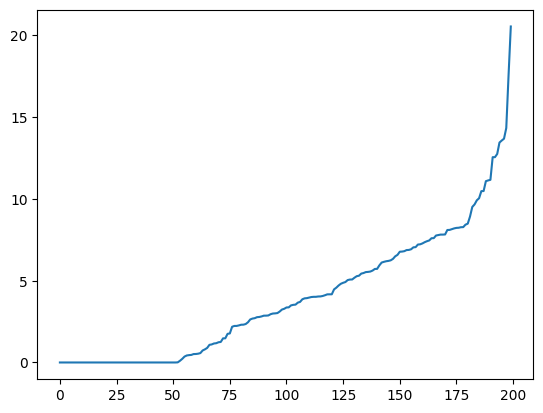

In [15]:
plt.plot(np.sort(c - C@x))

In [ ]:
import cvxpy as cp
n = A.shape[1]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
neg_log_likelihood = cp.sum(
    cp.multiply(w,cp.logistic(A @ beta)- cp.multiply(y, A @ beta))
)
regularization = beta.T@Q@beta/2

problem  = cp.Problem(cp.Minimize(
    (neg_log_likelihood + regularization)),[C @ beta <= c]
)
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 17 08:54:43 PM: Your problem has 500 variables, 200 constraints, and 0 parameters.
(CVXPY) Apr 17 08:54:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 08:54:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 08:54:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 08:54:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 08:54:43 PM: Compiling problem (target solver=CLARABEL

In [138]:
print(f(A@x) + (1/2) *x.T@Q@x)

cvx_x = beta.value
print(f(A@cvx_x) + (1/2) *cvx_x.T@Q@cvx_x)

68542.6735196966
68542.67355710643


In [22]:
cvx_x - x

array([ 1.88304223e-06,  6.61183275e-06,  1.96638301e-06, -4.12074586e-08,
       -6.02499955e-06,  1.10058918e-06, -6.10930961e-07, -1.26946839e-06,
        5.88587145e-07,  6.00444789e-07, -1.00792179e-08,  2.13289630e-06,
       -1.92164394e-06,  1.98446058e-06, -4.71918464e-06,  2.48029504e-06,
       -8.10489266e-07,  7.49122216e-06,  2.10166768e-06, -2.29564910e-06,
        1.44871601e-07, -2.89828361e-06, -5.15847388e-06,  9.14257737e-07,
       -1.74684648e-06,  1.02833231e-06, -1.56754350e-05, -5.31380687e-07,
        5.18384500e-07, -3.40708443e-07,  4.43635682e-06,  1.30159259e-06,
       -3.78598153e-06,  2.37993245e-07,  5.00879387e-07,  5.31418336e-07,
       -1.72539662e-06, -1.81282658e-06, -2.21485332e-06, -2.74029104e-06,
       -3.99108030e-06,  1.21493751e-06,  6.06727824e-08,  1.36522697e-06,
        5.72811232e-07,  2.98111301e-06,  1.10734558e-07, -3.51312001e-06,
       -2.34090067e-06, -7.99061721e-07, -1.09719711e-06,  4.94875204e-07,
       -2.65096531e-06,  

In [177]:
print(problem.value -f(A@x) - (1/2) *x.T@Q@x)

-6.8239253430135705e-06
